In [1]:
import os
import cv2
import shutil
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets


In [2]:
print(os.listdir('Train_Test_Valid'))
print(os.listdir('Train_Test_Valid/Train'))  # Train 폴더의 목록
print(os.listdir('Train_Test_Valid/test'))   # test 폴더의 목록
print(os.listdir('Train_Test_Valid/valid'))  # valid 폴더의 목록

['valid', 'test', 'Train']
['mauve_stinger_jellyfish', 'barrel_jellyfish', 'moon_jellyfish', 'lions_mane_jellyfish', 'blue_jellyfish', 'compass_jellyfish']
['mauve_stinger_jellyfish', 'barrel_jellyfish', 'lions_mane_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'Moon_jellyfish']
['mauve_stinger_jellyfish', 'barrel_jellyfish', 'lions_mane_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'Moon_jellyfish']


In [3]:
# 데이터 경로 설정
data_dir = 'Train_Test_Valid'
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')


In [4]:
# 모든 .ipynb_checkpoints 폴더 제거
for root, dirs, files in os.walk(data_dir):
    if '.ipynb_checkpoints' in dirs:
        checkpoint_path = os.path.join(root, '.ipynb_checkpoints')
        shutil.rmtree(checkpoint_path)

In [5]:


# 이미지 전처리 변환 정의
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 이미지를 128x128 크기로 조정
    transforms.ToTensor(),          # 이미지를 텐서로 변환
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 정규화
])


In [6]:

# ImageFolder를 사용하여 훈련 및 테스트 데이터셋 불러오기
# 데이터 구조가 다음과 같이 되어 있다고 가정합니다.
#   Jellyfish/
#       train/
#           barrel_jellyfish/
#               ...
#           blue_jellyfish/
#               ...
#           ...
#       test/
#           barrel_jellyfish/
#               ...
#           blue_jellyfish/
#               ...
#           ...


# ImageFolder를 사용하여 훈련, 테스트 및 검증 데이터셋 불러오기
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

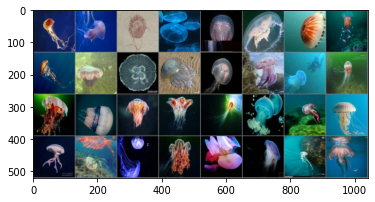

compass_jellyfish mauve_stinger_jellyfish mauve_stinger_jellyfish moon_jellyfish mauve_stinger_jellyfish moon_jellyfish compass_jellyfish lions_mane_jellyfish


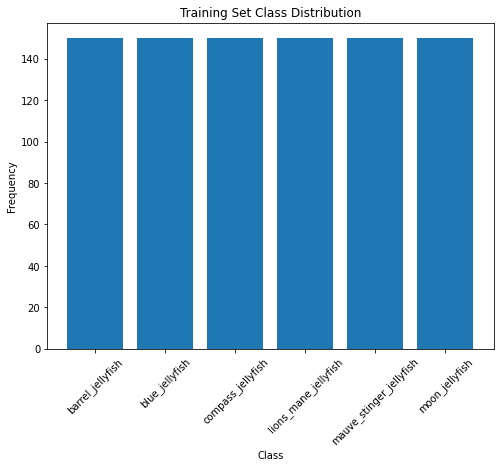

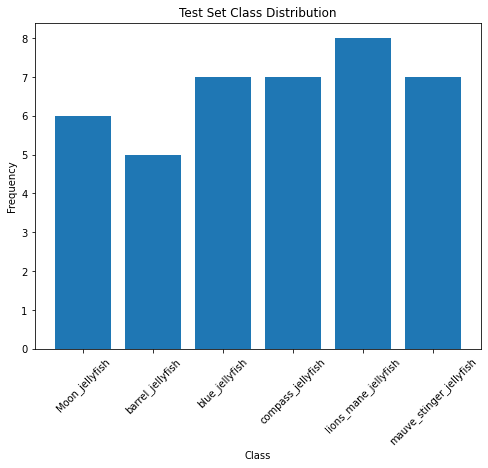

In [7]:

# EDA: 훈련 데이터에서 몇 개의 이미지를 시각화합니다.
def imshow(img):
    img = img / 2 + 0.5  # 정규화를 되돌립니다.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 훈련 데이터로더에서 일부 이미지 및 라벨 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 시각화
imshow(torchvision.utils.make_grid(images))
print(' '.join('%10s' % train_dataset.classes[labels[j]] for j in range(8)))

# 클래스 분포를 시각화하는 함수
def plot_class_distribution(dataset, title='Class Distribution'):
    # dataset.targets에는 각 이미지의 클래스 인덱스가 들어있습니다.
    class_counts = np.bincount(dataset.targets)
    class_names = dataset.classes
    plt.figure(figsize=(8, 6))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# 훈련 데이터셋 클래스 분포 시각화
plot_class_distribution(train_dataset, title='Training Set Class Distribution')

# 테스트 데이터셋 클래스 분포 시각화
plot_class_distribution(test_dataset, title='Test Set Class Distribution')


In [8]:

# 학습에 사용할 장치 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")


Using cuda device


In [9]:

# [코드 2-10] LeNet 모델 정의 (클래스 수: 6개)
class LeNet(nn.Module):
    def __init__(self, num_classes=6):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 입력 이미지 크기가 128x128이라고 가정:
        # 첫 번째 conv+pool 후: (128-4)/2 = 62
        # 두 번째 conv+pool 후: (62-4)/2 = 29 
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  # 6개의 클래스로 분류

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)  # 특성 맵을 평탄화
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
# 원래 LeNet-5 구조
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class LeNet(nn.Module):
#     def __init__(self, num_classes=10):  # 기본적으로 MNIST는 10개의 클래스
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # 입력 채널: 1(흑백), 출력 채널: 6
#         self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # 평균 풀링 사용
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 입력 채널: 6, 출력 채널: 16
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 입력 크기: 16 * 5 * 5
#         self.fc2 = nn.Linear(120, 84)  # 두 번째 완전 연결층
#         self.fc3 = nn.Linear(84, num_classes)  # 출력 클래스 수: 10

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 합성곱 + 풀링
#         x = self.pool(F.relu(self.conv2(x)))  # 두 번째 합성곱 + 풀링
#         x = x.view(-1, 16 * 5 * 5)  # 특성 맵을 평탄화
#         x = F.relu(self.fc1(x))  # 첫 번째 완전 연결층
#         x = F.relu(self.fc2(x))  # 두 번째 완전 연결층
#         x = self.fc3(x)  # 출력층
#         return x

# # 모델 생성
# model = LeNet(num_classes=10)  # MNIST 데이터셋은 기본적으로 10개의 클래스
# print(model)


In [11]:

# 모델 학습 함수 정의 (검증 추가)
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=30, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # 검증 단계
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_acc = correct / total
        print(f'Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}')
    return model


# 모델 인스턴스 생성, 손실 함수 및 옵티마이저 정의
model = LeNet(num_classes=len(train_dataset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [12]:
# 모델 학습
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=30, device=device)


Epoch 1/30, Loss: 1.7688, Accuracy: 0.2833
Validation Loss: 1.7849, Validation Accuracy: 0.2051
Epoch 2/30, Loss: 1.6489, Accuracy: 0.3778
Validation Loss: 1.8747, Validation Accuracy: 0.1795
Epoch 3/30, Loss: 1.4931, Accuracy: 0.4256
Validation Loss: 2.0327, Validation Accuracy: 0.1282
Epoch 4/30, Loss: 1.3655, Accuracy: 0.4633
Validation Loss: 2.2216, Validation Accuracy: 0.1282
Epoch 5/30, Loss: 1.2739, Accuracy: 0.5156
Validation Loss: 2.3764, Validation Accuracy: 0.1026
Epoch 6/30, Loss: 1.2153, Accuracy: 0.5267
Validation Loss: 2.5695, Validation Accuracy: 0.1282
Epoch 7/30, Loss: 1.1586, Accuracy: 0.5578
Validation Loss: 2.6409, Validation Accuracy: 0.1538
Epoch 8/30, Loss: 1.0955, Accuracy: 0.5889
Validation Loss: 2.7192, Validation Accuracy: 0.1026
Epoch 9/30, Loss: 1.0487, Accuracy: 0.6100
Validation Loss: 2.8396, Validation Accuracy: 0.1282
Epoch 10/30, Loss: 1.0110, Accuracy: 0.6244
Validation Loss: 2.8563, Validation Accuracy: 0.1026
Epoch 11/30, Loss: 0.9897, Accuracy: 0.

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)